# Prediccion del Valor del Bitcoin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch

* Lo primero que se hará sera entrenar un modelo con datos de años anteriores de los valores de BTC y ETH, con el fin de predecir el valor que deberian haber tenido y compararlo con el valor verdadero.
    * El fin de esto es estimar cuanto dinero se perdio calculando el area entre curvas 

In [2]:
######### Data Train BTC #############
df_BTC= pd.read_excel("BTC_Train_2.xlsx")
date=pd.to_datetime(df_BTC['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_BTC=df_BTC.set_index(datetime_index).drop(['Date'],axis=1)
#df_BTC.head()

######### Data Validation BTC #############
df_BTC_Validation= pd.read_excel("BTC_Validation.xlsx")
date=pd.to_datetime(df_BTC_Validation['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_BTC_Validation=df_BTC_Validation.set_index(datetime_index).drop(['Date'],axis=1)
#df_BTC_Validation.head()

######### Data Testing BTC #############
df_BTC_testing= pd.read_excel("BTC_Test.xlsx")
date=pd.to_datetime(df_BTC_testing['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_BTC_testing=df_BTC_testing.set_index(datetime_index).drop(['Date'],axis=1)
#df_BTC_testing.head()

######### Data Train ETH #############
df_ETH= pd.read_excel("ETH_Train.xlsx")
date=pd.to_datetime(df_ETH['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_ETH=df_ETH.set_index(datetime_index).drop(['Date'],axis=1)
#df_ETH.head()

######### Data Validation ETH #############
df_ETH_Validation= pd.read_excel("ETH_Validation.xlsx")
date=pd.to_datetime(df_ETH_Validation['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_ETH_Validation=df_ETH_Validation.set_index(datetime_index).drop(['Date'],axis=1)
#df_ETH_Validation.head()

######### Data Testing ETH #############
df_ETH_testing= pd.read_csv("dataset_eth.csv")
date=pd.to_datetime(df_ETH_testing['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_ETH_testing=df_ETH_testing.set_index(datetime_index).drop(['Date'],axis=1)
#df_ETH_testing.head()

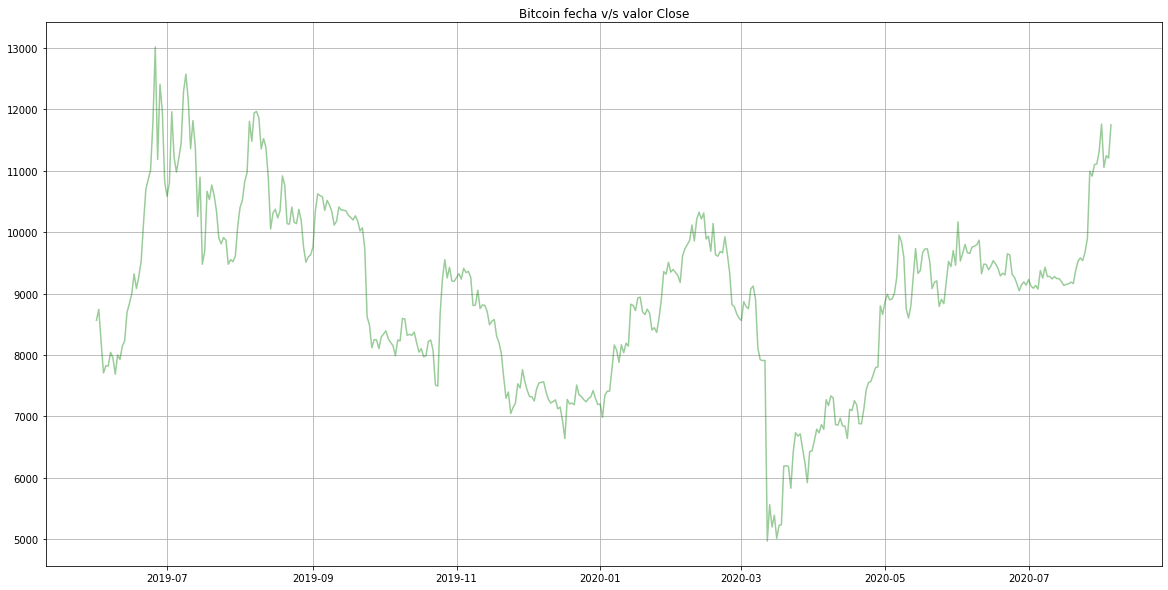

In [3]:
grafico_btc_close=plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Bitcoin fecha v/s valor Close')
plt.plot(df_BTC_testing.index,df_BTC_testing['Close'],c='g',alpha=0.4)

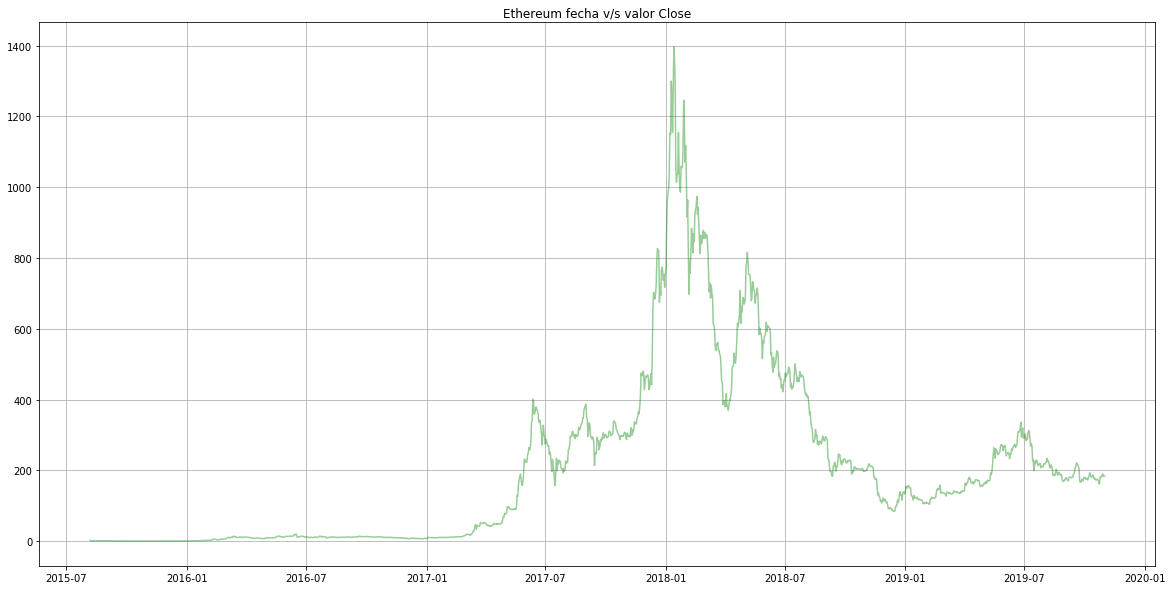

In [4]:
grafico_eth_close=plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Ethereum fecha v/s valor Close')
plt.plot(df_ETH.index,df_ETH['Close'],c='g',alpha=0.4)


# Predicción de series de tiempo
## Procesamiento, Escalamiento y Transformacion de la data

In [5]:
from sklearn.preprocessing import StandardScaler

df_btc_train=df_BTC
df_btc_val=df_BTC_Validation
df_btc_test=df_BTC_testing

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_btc_train[["Close"]].values)
val_arr = scaler.transform(df_btc_val[["Close"]].values)
test_arr = scaler.transform(df_btc_test[["Close"]].values)

In [6]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [7]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [8]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled Close Price")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

Como vimos a lo largo del curso, cuando intentamos hacer una regresion o clasificacion, tenemos un conjunto de features o caracteristicas y un objetivo que queremos predecir.

Para este caso ambos son el precio de cierre de jornada de bitcoin

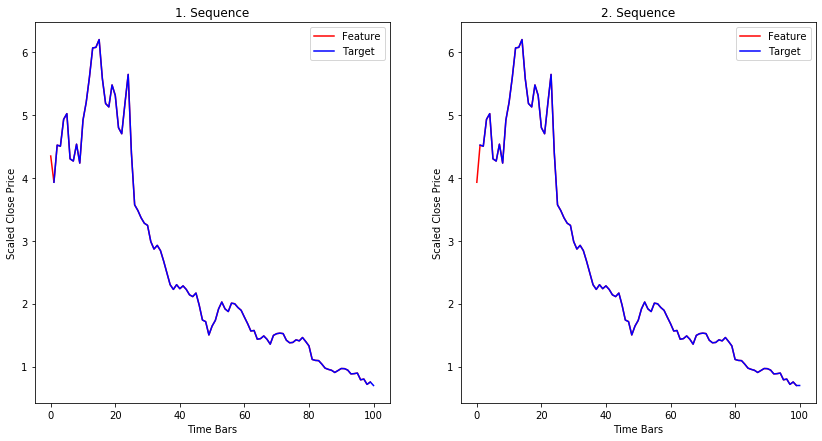

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

### Redes neuronales recursivas

Las Redes Neuronales Recursivas (RNN) estan especializadas para captar secuencias (Cosas que pasan en el tiempo una tras de otra).

* La red neuronal tiene bloques y cada bloque tiene una entrada y una salida.

* Los bloques estan conectados unos con otros, hasta que el ultimo bloque es el que predice.

* Ademas Sobre los bloques se pueden hacer capas que ayuden a predecir de mejor manera. Mientras mas bloques se predice con mayor precision. Estos bloques van haciendo predicciones en base a la probabilidad de que un valor especifico se genere luego de el valor en el que nos encontramos.
    * Mientras mas capas de neuronas se generen, mayor sera la red de probabilidades y tambien su complejidad.

* Estas redes tienen memoria a corto plazo, esto quiere decir que predicen mejor en menor cantidad de bloques.

Para mejorar esto se utiliza *LSTM (Long Short Term Memory Neural Network)*

## Long Short Term Memory Neural Network

Las LSTM recuerdan datos relevantes en la secuencia y preservarlo por un periodo de tiempo, por lo que puede funcionar tanto a corto plazo como a largo plazo. Esto lo hace mediante una celda de estado en la cual se pueden añadir o eliminar datos que se quieren mantener o sacar de una red neuronal

In [10]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [11]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [12]:
def generate_sequence(scaler, model, x_sample, future=332):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [13]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

## Entrenando la LSTM

Se entrena la LSTM con 18 hidden-unities, que son los bloques LSTM. Elegir un numero menor de hidden-unities es utilizado para que sea menos posible que la LSTM memorice perfectamente la secuencia 

In [14]:
model_1 = Model(input_size=1, hidden_size=18, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-2)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [15]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.51. Validation loss: 3.38. Avg future: 0.00. Elapsed time: 0.93s.
Epoch 2 Train loss: 0.33. Validation loss: 2.45. Avg future: 0.00. Elapsed time: 0.85s.
Epoch 3 Train loss: 0.24. Validation loss: 1.17. Avg future: 0.00. Elapsed time: 0.86s.
Epoch 4 Train loss: 0.13. Validation loss: 0.54. Avg future: 0.00. Elapsed time: 0.91s.
Epoch 5 Train loss: 0.11. Validation loss: 0.64. Avg future: 0.00. Elapsed time: 0.83s.
Epoch 6 Train loss: 0.09. Validation loss: 0.56. Avg future: 0.00. Elapsed time: 0.86s.
Epoch 7 Train loss: 0.08. Validation loss: 0.45. Avg future: 0.00. Elapsed time: 0.82s.
Epoch 8 Train loss: 0.08. Validation loss: 0.35. Avg future: 0.00. Elapsed time: 0.83s.
Epoch 9 Train loss: 0.07. Validation loss: 0.27. Avg future: 0.00. Elapsed time: 0.81s.
Epoch 10 Train loss: 0.06. Validation loss: 0.22. Avg future: 0.00. Elapsed time: 0.78s.
Epoch 11 Train loss: 0.06. Validation loss: 0.22. Avg future: 0.00. Elapsed time: 0.86s.
Epoch 12 Train loss: 0.06. Val

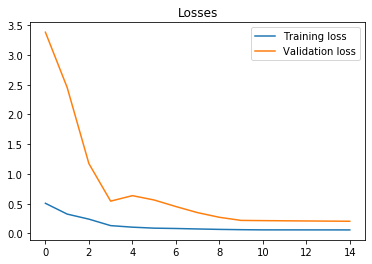

In [16]:
optimization_1.plot_losses()

Para evaluar el modelo de pruebas, se establece el parametro future en 5 barras de tiempo (que en nuestro caso es 5 dias), lo que significa que la salida de cada bloque del modelo mostraria donde cree que estaria el valor del precio en 5 dias más.

Test loss 0.6586


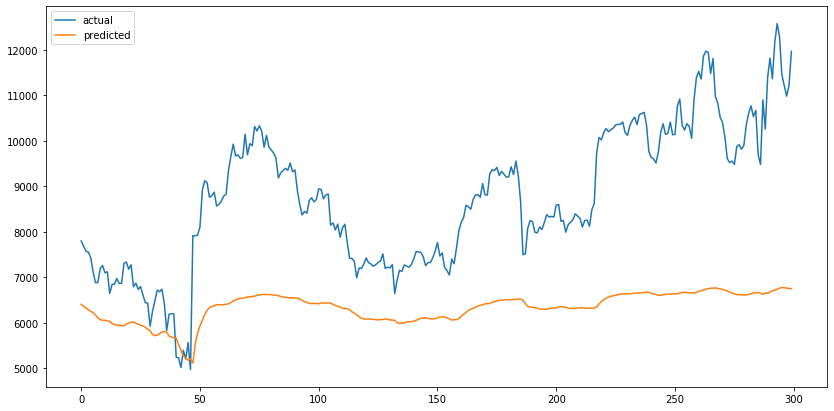

In [17]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

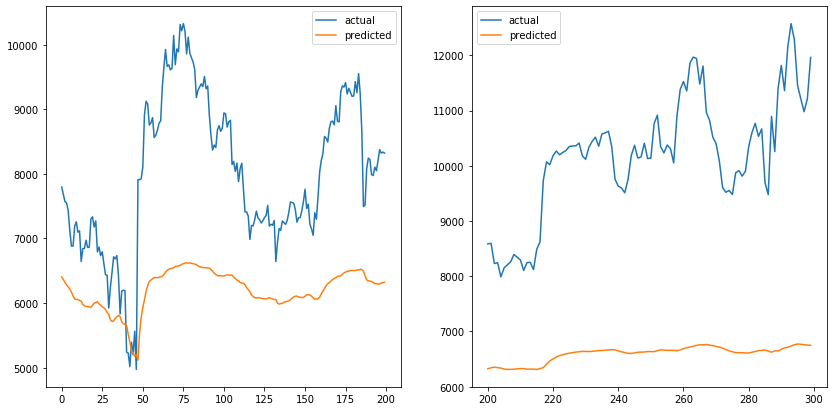

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[0:200].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[200:400].plot(ax=axes[1], figsize=(14, 7))

In [19]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_btc_test[["Close"]].values
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

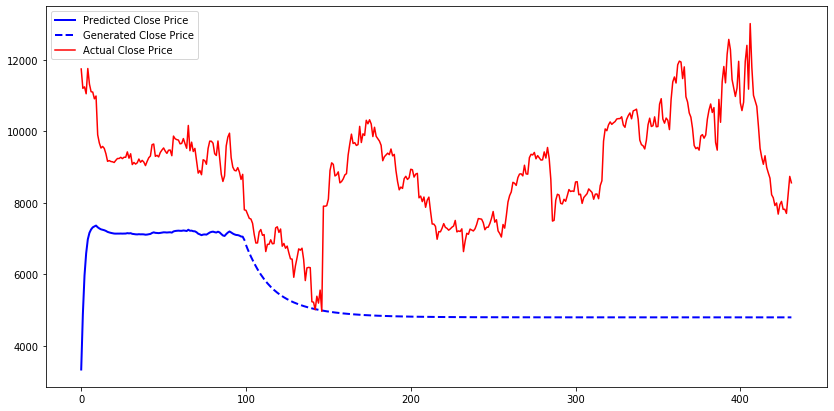

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted Close Price")
plt.plot(range(100, 432), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated Close Price")
plt.plot(range(0, 432), y_sample, color="red", label="Actual Close Price")
plt.legend()

El comportamiento anterior podría ocurrir porque el modelo fue entrenado sólo con entradas verdaderas y nunca con entradas generadas. Cuando el modelo se alimenta de la salida generada en la entrada, hace un mal trabajo al generar los siguientes valores. El *Teacher Forcing* es un concepto que trata este tema.

## Teacher Forcing

El *Teacher Forcing* es un metodo para entrenar RNN, que utilizan como entrada la salida de un bloque LSTM anterior. Esto permite que la secuencia sea mas precisa, pero tambien puede hacer menos estable el modelo y no converger.

Para realizar *Teacher forcing* se utilizara Scheduled sampling, que es una extension de *Teacher Forcing*. El modelo utilizará su salida generada como una entrada con una cierta probabilidad durante el entrenamiento. Al principio, la probabilidad de que un modelo vea su salida generada es pequeña y luego aumenta gradualmente durante el entrenamiento.

In [21]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-2)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)

In [22]:
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True)

Epoch 1 Train loss: 0.47. Validation loss: 1.94. Avg future: 30.22. Elapsed time: 0.99s.
Epoch 2 Train loss: 0.19. Validation loss: 0.64. Avg future: 30.33. Elapsed time: 0.92s.
Epoch 3 Train loss: 0.16. Validation loss: 0.59. Avg future: 24.11. Elapsed time: 0.94s.
Epoch 4 Train loss: 0.36. Validation loss: 0.72. Avg future: 31.00. Elapsed time: 0.93s.
Epoch 5 Train loss: 0.11. Validation loss: 0.99. Avg future: 29.78. Elapsed time: 0.96s.
Epoch 6 Train loss: 0.13. Validation loss: 0.75. Avg future: 25.56. Elapsed time: 0.99s.
Epoch 7 Train loss: 0.10. Validation loss: 0.41. Avg future: 22.00. Elapsed time: 0.91s.
Epoch 8 Train loss: 0.07. Validation loss: 0.21. Avg future: 30.44. Elapsed time: 0.94s.
Epoch 9 Train loss: 0.07. Validation loss: 0.16. Avg future: 23.44. Elapsed time: 0.92s.
Epoch 10 Train loss: 0.05. Validation loss: 0.12. Avg future: 24.00. Elapsed time: 0.90s.
Epoch 11 Train loss: 0.04. Validation loss: 0.06. Avg future: 30.00. Elapsed time: 0.94s.
Epoch 12 Train loss

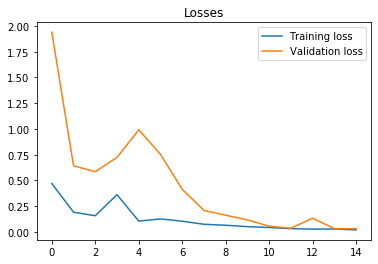

In [23]:
optimization_2.plot_losses()

Test loss 0.0611


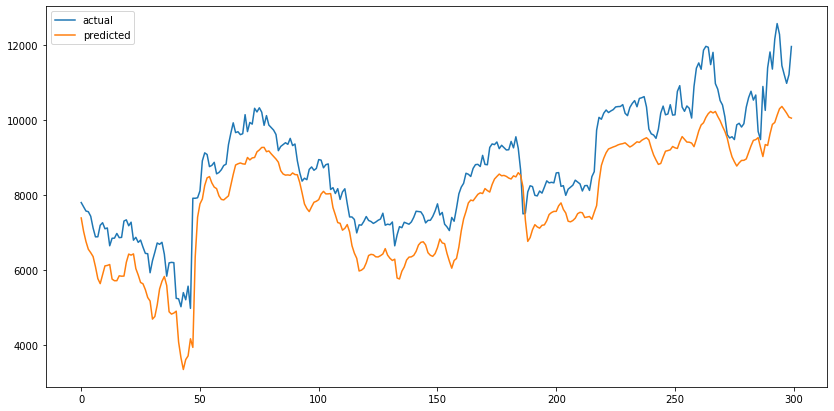

In [24]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
df_result_2 = to_dataframe(actual_2, predicted_2)
df_result_2 = inverse_transform(scaler, df_result_2, ["actual", "predicted"])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

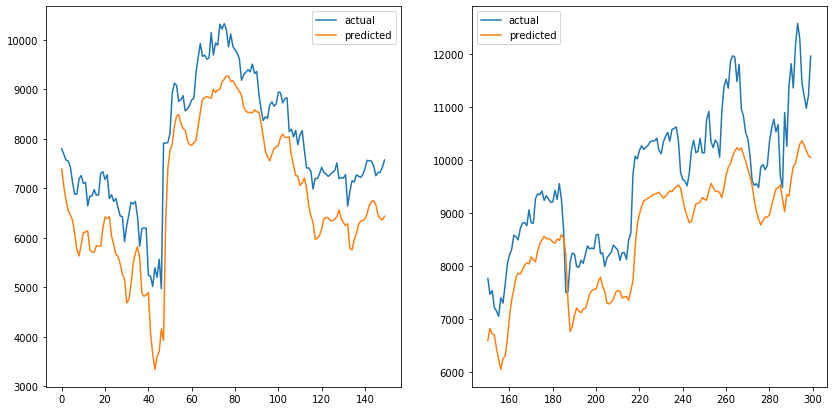

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_2.iloc[0:150].plot(ax=axes[0], figsize=(14, 7))
df_result_2.iloc[150:332].plot(ax=axes[1], figsize=(14, 7))

In [26]:
y_pred2 = generate_sequence(scaler, optimization_2.model, x_sample)

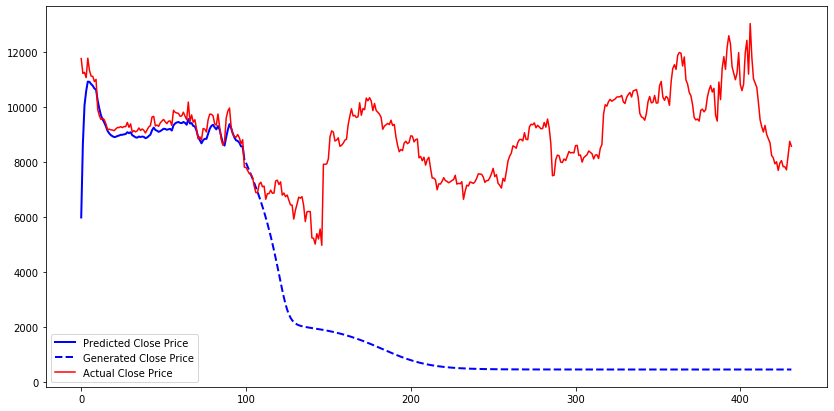

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred2[0][:100], color="blue", lw=2, label="Predicted Close Price")
plt.plot(range(100, 432), y_pred2[0][100:], "--", color="blue", lw=2, label="Generated Close Price")
plt.plot(range(0, 432), y_sample, color="red", label="Actual Close Price")
plt.legend()

La secuencia generada a partir del modelo entrenado con *Teacher Forcing* necesita más tiempo para converger. Otra observación sobre la secuencia generada es que cuando está aumentando, continuará aumentando hasta algún punto, luego comenzará a disminuir y el patrón se repetirá hasta que la secuencia converja.